# Helmholtz 1D Multilevel: Constant $k$, Repetitive Coarsening (Detailed Level-by-Level Coarsening Development)
* Constant $k$.
* Discretization: 5-point (4th order).
* Fixed-domain problem; non-repetitive, so we generate TVs over entire domain.
* Fix aggregate size $a$ and $n_c$ (# principal components) over entire domain. Overlap the last two aggregates if needed.
* Optimize $a, n_c$ to maximize the mock cycle predicted error reduction efficiency.

In [15]:
import collections
import logging
import numpy as np
import matplotlib.pyplot as plt
import helmholtz as hm
import pandas as pd
import scipy.sparse
import sklearn.metrics.pairwise
import sys
from numpy.ma.testutils import assert_array_almost_equal
from scipy.linalg import eig, norm, svd
from scipy.sparse.linalg import eigs
from scipy import optimize

%load_ext autoreload
%autoreload 2

np.set_printoptions(linewidth=500, precision=3, suppress=True, threshold=100000)
for handler in logging.root.handlers[:]: logging.root.removeHandler(handler)
logging.basicConfig(stream=sys.stdout, level=logging.INFO, format="%(levelname)-8s %(message)s",
                    datefmt="%a, %d %b %Y %H:%M:%S")

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.options.display.float_format = "{:,.2f}".format

logger = logging.getLogger("main")
_LOGGER = logger

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
# Fixed seed for reproducible results.
np.random.seed(0)

# Domain size.
n = 96
# Scaled wave number.
kh = 0.7

repetitive = True

# Number of test vectors.
num_examples = 3
threshold = 0.1

# Boottstrapping parameters.
interpolation_method = "ls"
neighborhood = "extended" #"aggregate" # "extended"
num_test_examples = 5
leeway_factor = 1.3

## Shrinkage Factor
Given an iterative method, we can calculate whether it's a good smoothing candidate using the **shrinkage factor** $\mu$, even before measuring its mock cycle rate (which measures the combination of the smoother andcoarsening operator $R$).

* Start from $5$ different random starts $x_0 = rand[-1,1]$, for each  apply the method for $A x = 0$ to obtain iterates $x_1, x_2, \dots$.
* For each iterate, calculate residual norm $r_i := \|A x_i\|_2$ and reduction per sweep, $\mu_i := (r_i / r_0)^{\frac{1}{i}}$, $i = 1, 2, \dots$.
* Average $\mu_i$ over the $5$ starts.
* Terminate the method at $j = i + 3$, where $i = argmin_i \mu_i$ and set $\mu \leftarrow \mu_j$.

## Level 0->1 Coarsening

### Relaxation Shrinkage Factor

PODR = point of diminishing returns
Efficiency = residual reduction per sweep
kh 0
INFO     Iter     |r|                         |x|         RER
INFO     0     1.406e+00                    4.468e-01    3.139
INFO     1     7.628e-01 (0.544) [0.544]    3.342e-01    2.288 (0.728)
INFO     2     4.353e-01 (0.572) [0.558]    2.811e-01    1.561 (0.682)
INFO     3     2.723e-01 (0.627) [0.580]    2.539e-01    1.086 (0.695)
INFO     4     1.864e-01 (0.686) [0.606]    2.380e-01    0.795 (0.732)
INFO     5     1.391e-01 (0.746) [0.632]    2.276e-01    0.622 (0.782)
INFO     6     1.117e-01 (0.803) [0.658]    2.201e-01    0.516 (0.831)
INFO     7     9.389e-02 (0.840) [0.681]    2.144e-01    0.444 (0.863)
INFO     8     8.141e-02 (0.867) [0.702]    2.099e-01    0.393 (0.886)
INFO     9     7.202e-02 (0.884) [0.720]    2.062e-01    0.353 (0.900)
INFO     10    6.475e-02 (0.898) [0.737]    2.030e-01    0.322 (0.912)
Kac   conv 0.90 shrinkage 0.70 PODR RER 0.39 after  8 sweeps. Work  1 efficiency 0

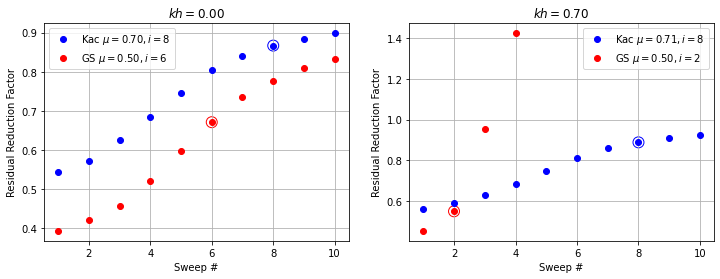

In [10]:
kh_values = [0, kh]
fig, axs = plt.subplots(1, len(kh_values), figsize=(12, 4))

kaczmarz = lambda a: hm.solve.relax.KaczmarzRelaxer(a, scipy.sparse.eye(a.shape[0]))
gs = lambda a: hm.solve.relax.GsRelaxer(a)
work = 1

print("PODR = point of diminishing returns")
print("Efficiency = residual reduction per sweep")
# Kaczmarz.
for kh_value, ax in zip(kh_values, axs):
    print("kh", kh_value)
    a_kh = hm.linalg.helmholtz_1d_5_point_operator(kh_value, n).tocsr()
    operator = lambda x: a_kh.dot(x)

    for title, relax, color in zip(("Kac", "GS"), (kaczmarz, gs), ("blue", "red")):
        method = relax(a_kh)
        factor, num_sweeps, residual, conv, rer, conv_factor = hm.solve.smoothing.shrinkage_factor(
            operator, lambda x, b: method.step(x, b), (a_kh.shape[0], ), 
            print_frequency=1, max_sweeps=10, slow_conv_factor=1.1, leeway_factor=leeway_factor)
        hm.solve.smoothing.plot_diminishing_returns_point(factor, num_sweeps, conv, ax, title=title, color=color)
        print("{:<5s} conv {:.2f} shrinkage {:.2f} PODR RER {:.2f} after {:>2d} sweeps. Work {:>2d} efficiency {:.2f}".format(
            title, conv_factor, factor, np.mean(rer[num_sweeps]), num_sweeps, work, np.mean(residual[num_sweeps] / residual[0]) ** (1/(num_sweeps * work))))
    
    ax.set_title(r"$kh = {:.2f}$".format(kh_value))
    ax.legend()

The point of diminishing returns in each scatterplot is circled.

This estimate seems to give a reasonable estimate for both $kh$ values and both relaxation schemes (albeit not a quantitative smoothing factor, which can only be defined based on a coarsening), showing that GS is a better smoother for both $kh = 0, 0.5$, but slightly diverges for $kh = 0.5$. The RER at the point of diminishing returns is much smaller.

Averaging over multiple random starts helps reduce noise, as well as assuming a constant reduction per sweep in the initial sweeps (as opposed to a linear model, say). We are only interested in a rough estimate.

**TODO: output asymptotic convergence factor a little past PODR to see if relax diverges.**

### Coarsening: Optimizing $a$, $n_c$

In [11]:
a = hm.linalg.helmholtz_1d_5_point_operator(kh, n).tocsr()
a0 = a
level = hm.setup.hierarchy.create_finest_level(a)

In [12]:
_LOGGER.info("kh {}".format(kh))
x_log = []
r_log = []

# Initialize hierarchy to 1-level and fine-level test functions to random.
finest = 0
multilevel = hm.hierarchy.multilevel.Multilevel.create(level)

_LOGGER.info("Relax at level {} size {}".format(finest, level.size))
b = np.zeros((a.shape[0], num_examples))

factor, num_sweeps, residual, conv, rer, relax_conv_factor = hm.solve.smoothing.shrinkage_factor(
    operator, lambda x, b: level.relax(x, b), (a_kh.shape[0], ), 
    print_frequency=None, max_sweeps=20, slow_conv_factor=1.1)
_LOGGER.info("Relax conv {:.2f} shrinkage {:.2f} PODR RER {:.2f} after {} sweeps. Work {:.1f} eff {:.2f}".format(
    relax_conv_factor, factor, np.mean(rer[num_sweeps]), num_sweeps, work, np.mean(residual[num_sweeps] / residual[0]) ** (1/(num_sweeps * work))))

# TODO(orenlivne): generalize to d-dimensions. This is specific to 1D.
x = hm.solve.run.random_test_matrix((a.shape[0],), num_examples=num_examples)
# Improve vectors with 1-level relaxation.
x_log.append(x)

_LOGGER.info("Generating TVs with {} sweeps".format(num_sweeps))
x, _ = hm.solve.run.run_iterative_method(
    level.operator, lambda x: level.relax(x, b), x, num_sweeps=num_sweeps)
_LOGGER.info("RER {:.3f}".format(norm(a.dot(x)) / norm(x)))
x_log.append(x)

INFO     kh 0.7
INFO     Relax at level 0 size 96
INFO     Relax conv 0.93 shrinkage 0.65 PODR RER 0.59 after 5 sweeps. Work 1.0 eff 0.65
INFO     Generating TVs with 5 sweeps
INFO     RER 0.634


In [13]:
# Calculate mock cycle predicted efficiency.
aggregate_size_values = np.array([2, 4, 6])
nu_values = np.arange(1, 5, dtype=int)
# TODO: determine this based on cycle index.
max_conv_factor = 0.3

coarsener = hm.setup.coarsening_uniform.UniformCoarsener(level, x, aggregate_size_values, nu_values, repetitive=repetitive)
r, aggregate_size, nc, cr, mean_energy_error, nu, mock_conv, mock_work, mock_efficiency = \
    coarsener.get_optimal_coarsening(max_conv_factor)
print("kh {:.2f} R {} a {} nc {} cr {:.2f} mean_energy_error {:.4f}; mock cycle nu {} conv {:.2f} efficiency {:.2f}".format(
  kh, r.shape, aggregate_size, nc, cr, mean_energy_error, nu, mock_conv, mock_efficiency))

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [ ]:
info = coarsener.get_coarsening_info(1)
columns=("i", "a", "nc", "cr", "Energy Error", "nu", "conv", "work", "eff")
pd.DataFrame(info).rename(columns=dict(enumerate(columns))).astype(
    {"i": "int32", "a": "int32", "nc": "int32", "nu": "int32"})

The optimal coarsening (based on mock cycle efficiency) is for a larger aggregate ($4/2$) only for a sufficiently large $kh$, of $\approx 0.7$. Even at $kh = 0.5$, $2/1$ coarsening is (very slightly) better.

### Build Coarse Level: Two-level Bootstrap Cycle

In [ ]:
max_levels = 2
num_bootstrap_steps = 1

# Bootstrap with an increasingly deeper hierarchy (add one level at a time).
num_levels = 2
_LOGGER.info("bootstrap on grid size {} with {} levels".format(x.shape[0], max_levels))
_LOGGER.info("-" * 80)
for i in range(num_bootstrap_steps):
    _LOGGER.info("Bootstrap step {}/{}".format(i + 1, num_bootstrap_steps))
    # Set relax_conv_factor to a high value so that we never append a bootstrap vector to the TV set.
    x, multilevel = hm.setup.auto_setup.bootstap(
        x, multilevel, num_levels, 2.0,
        num_sweeps=num_sweeps, interpolation_method=interpolation_method, neighborhood=neighborhood, repetitive=repetitive)
    x_log.append(x)
    r_log.append(multilevel[1].r)
    _LOGGER.info("RER {:.6f}".format(norm(a.dot(x)) / norm(x)))
    _LOGGER.info("-" * 80)

<!-- ### Interpolation Error -->

In [ ]:
# p = multilevel[1].p
# r = multilevel[1].r
# x_fit, x_test = x[:, :-num_test_examples], x[:, -num_test_examples:]
# e = x - p.dot(r.dot(x))
# error = norm(e, axis=0) / norm(x, axis=0)
# error_a = norm(level.a.dot(e), axis=0) / norm(x, axis=0)
# print(error_a)
# # print(e[2])
# # print(p[2].todense())
# # print(x[2])

### Level 1 Relaxation Shrinkage Factor

In [ ]:
level = multilevel[1]
a = level.a
x_random = hm.solve.run.random_test_matrix((a.shape[0],), num_examples=num_examples)
b = np.zeros_like(x_random)

work = 1
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
title = "kac"
relax = kaczmarz
color = "blue"

relax = lambda x, b: level.relax(x, b)
factor, num_sweeps, residual, conv, rer, conv_factor = hm.solve.smoothing.shrinkage_factor(
    level.operator, relax, (a.shape[0], ), print_frequency=1, max_sweeps=10, slow_conv_factor=2, 
    num_examples=5, leeway_factor=leeway_factor)
hm.solve.smoothing.plot_diminishing_returns_point(factor, num_sweeps, conv, ax, title=title, color=color)
print("{:<5s} conv {:.2f} shrinkage {:.2f} PODR RER {:.2f} after {:>2d} sweeps. Work {:>2d} efficiency {:.2f}".format(
    title, conv_factor, factor, np.mean(rer[num_sweeps]), num_sweeps, work, np.mean(residual[num_sweeps] / residual[0]) ** (1/(num_sweeps * work))))

ax.set_title(r"$kh = {:.2f}$".format(kh))
ax.legend();

nu_coarsest = num_sweeps

The coarse-level relaxation is still a good smoother, even though less effective than the fine-level relaxation. This means we built reasonable coarse-level equations that can be solved without advanced relaxation design techniques.

### Relaxation Cycle Shrinkage
We compare a two-level relaxation cycle with $\nu_1=1, \nu_2=1, \nu_{coarse}=$ # relaxations until the coarse-level relaxation slows down, with fine-level Kaczmarz relaxation.

In [ ]:
hm.solve.smoothing.check_relax_cycle_shrinkage(
    multilevel, nu_pre=1, nu_post=1, nu_coarsest=nu_coarsest)

#### Observations
* The first cycle increases the residual! Unless enough relaxations (4) are performed at the finest level.
* Convergence is faster than relaxation ($0.4$ vs. $0.6$) until the slowdown.
* The RER at the PODR is a lot smaller than in relaxation.

## Level 1->2 Coarsening

### Two-level Bootstrapping

In [ ]:
num_examples = 5
max_levels = 2
num_bootstrap_steps = 1

x_log = []
r_log = []

# Initialize hierarchy to 1-level and fine-level test functions to random.
finest = 0
multilevel1 = hm.hierarchy.multilevel.Multilevel.create(level)
_LOGGER.info("Relax at level {} size {}".format(finest, level.size))
b = np.zeros((level.a.shape[0], num_examples))
factor, num_sweeps, residual, conv, rer, relax_conv_factor = hm.solve.smoothing.shrinkage_factor(
    level.operator, lambda x, b: level.relax(x, b), (level.a.shape[0], ), 
    print_frequency=None, max_sweeps=20, slow_conv_factor=1.1, leeway_factor=leeway_factor)
_LOGGER.info("Relax conv {:.2f} shrinkage {:.2f} PODR RER {:.2f} after {} sweeps. Work {:.1f} eff {:.2f}".format(
    relax_conv_factor, factor, np.mean(rer[num_sweeps]), num_sweeps, work, np.mean(residual[num_sweeps] / residual[0]) ** (1/(num_sweeps * work))))

# Start from random again. Level 0 doesn't exist here.
x = hm.solve.run.random_test_matrix((a.shape[0],), num_examples=num_examples)
x_log.append(x)

# Improve vectors with 1-level relaxation.
_LOGGER.info("Generating TVs with {} sweeps".format(num_sweeps))
x, _ = hm.solve.run.run_iterative_method(
    level.operator, lambda x: level.relax(x, b), x, num_sweeps=num_sweeps)
_LOGGER.info("RER {:.3f}".format(norm(a.dot(x)) / norm(x)))
x_log.append(x)

# Bootstrap with an increasingly deeper hierarchy (add one level at a time).
num_levels = 2
_LOGGER.info("bootstrap on grid size {} with {} levels".format(x.shape[0], max_levels))
_LOGGER.info("-" * 80)
for i in range(num_bootstrap_steps):
    _LOGGER.info("Bootstrap step {}/{}".format(i + 1, num_bootstrap_steps))
    # Set relax_conv_factor to a high value so that we never append a bootstrap vector to the TV set.
    x, multilevel1 = hm.setup.auto_setup.bootstap(
        x, multilevel1, num_levels, 2.0,
        num_sweeps=num_sweeps, interpolation_method=interpolation_method, neighborhood=neighborhood,
        repetitive=repetitive)
    x_log.append(x)
    r_log.append(multilevel1[1].r)
    _LOGGER.info("RER {:.6f}".format(norm(a.dot(x)) / norm(x)))
    _LOGGER.info("-" * 80)
    
# Merge the 1-2 hierarchy into the 0-1 to create 0-1-2.
multilevel.add(multilevel1[1])

Note that we are now able to reduce the RER of the TVs consisently with bootstrap cycles at level 1.

### Level 2 Relaxation Shrinkage

In [ ]:
level = multilevel[2]
print("Level size {}".format(level.size))
a = level.a
x_random = hm.solve.run.random_test_matrix((a.shape[0],), num_examples=num_examples)
b = np.zeros_like(x_random)

work = 1
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
title = "kac"
relax = kaczmarz
color = "blue"

relax = lambda x, b: level.relax(x, b)
factor, num_sweeps, residual, conv, rer, conv_factor = hm.solve.smoothing.shrinkage_factor(
    level.operator, relax, (a.shape[0], ), print_frequency=1, max_sweeps=20, slow_conv_factor=2, 
    num_examples=5, leeway_factor=leeway_factor)
hm.solve.smoothing.plot_diminishing_returns_point(factor, num_sweeps, conv, ax, title=title, color=color)
print("{:<5s} conv {:.2f} shrinkage {:.2f} PODR RER {:.2f} after {:>2d} sweeps. Work {:>2d} efficiency {:.2f}".format(
    title, conv_factor, factor, np.mean(rer[num_sweeps]), num_sweeps, work, np.mean(residual[num_sweeps] / residual[0]) ** (1/(num_sweeps * work))))

ax.set_title(r"$kh = {:.2f}$".format(kh))
ax.legend();

nu_coarsest = num_sweeps

In [ ]:
hm.solve.smoothing.check_relax_cycle_shrinkage(
    multilevel, max_sweeps=100,
    nu_pre=1, nu_post=1, nu_coarsest=3)

* Level 2 relaxation behaves weirdly: it slows down after exactly one sweep. One sweep is fast, then the residual reduction goes up, then down, then slowly back up again.
* The Level 1-2 min-cycle is not more efficient.

### Operators

#### Level 0

In [ ]:
pd.DataFrame(multilevel[0].a[:10,:10].todense())

#### Level 1

In [ ]:
pd.DataFrame(multilevel[1].a[:12, :12].todense())

In [ ]:
pd.DataFrame(multilevel[1].p[:10,:10].todense())

#### Level 2

In [ ]:
pd.DataFrame(multilevel[2].a[:12, :12].todense())

In [ ]:
pd.DataFrame(multilevel[2].p[:12, :12].todense())

## How Does the Coarse Variables Look Like?
Print rows of $R_L \cdot \dots \cdot R_1$ and columns of $P_1 \cdot \dots \cdot P_L$ (for $L$ levels of coarsening).

In [ ]:
r1 = multilevel[1].r
p1 = multilevel[1].p

r2 = multilevel[2].r
p2 = multilevel[2].p

p = p1.dot(p2)
r = r2.dot(r1)

In [ ]:
num_vars = 5
fig, axs = plt.subplots(num_vars, 4, figsize=(16, 12))
start_index = 10

col_titles = ("Level 1, P", "Level 1, R", "Level 2, P", "Level 1, R") 
for ax, col in zip(axs[0], col_titles):
    ax.set_title(col)
    
for i in range(num_vars):
    j = start_index + i
    
    ax = axs[i, 0]
    ax.plot(p1[:, j].nonzero()[0], p1[:, j].data)
    ax.grid(True)
    
    ax = axs[i, 1]
    ax.plot(r1[j].nonzero()[1], r1[j].data)
    ax.grid(True)
    
    ax = axs[i, 2]
    ax.plot(p[:, j].nonzero()[0], p[:, j].data, "r")
    ax.grid(True)
    
    ax = axs[i, 3]
    ax.plot(r[j].nonzero()[1], r[j].data, "r")
    ax.grid(True)

The coarse variables ($R$) look like wavelets. The interpolations ($P$) look like a sync, all makes sense.

## Eigenpairs of the Different Level Operators

In [ ]:
# Calculate eigenpairs at all levels.
vl = []
laml = []
for l, level in enumerate(multilevel):
    a = level.a
    lam, v = eig(a.todense())
    lam = np.real(lam)
    ind = np.argsort(np.abs(lam))
    lam = lam[ind]
    v = v[:, ind]
    vl.append(v)
    laml.append(lam)
    print(l, "lam", lam[:13])
    
# Interpolate eigenvectors at all levels to the finest level.
num_levels = len(multilevel)
vl_finest = []
for l in range(num_levels):
    v = vl[l]
    for k in range(l, 0, -1):
        v = multilevel[k].p.dot(v)
    vl_finest.append(v)

Looks like the smallest four eigenvalues are well approximated at all levels, to about $10\%$ error.

In [ ]:
np.abs(laml[1][:10] - laml[0][:10]) / np.abs(laml[0][:10]), np.abs(laml[2][:10] - laml[0][:10]) / np.abs(laml[0][:10])

### What Level 1 eigenvectors comprise the level 2 AZM?
We calculate $(v^2_i)^T (R_2 v^1)$, which gives us the spectral decomposition coefficients of the level 2 eigenvector $v^2_i$ in terms of the coarsened level 1 eigenvectors.

In [ ]:
num_ev = 8
fig, axs = plt.subplots(num_ev, num_levels + 1, figsize=(16, 16))

for col, ax in enumerate(axs[0][:-1]):
    ax.set_title("Level {}".format(col))
axs[0, -1].set_title("Level {} spectrum".format(num_levels))

for i in range(num_ev):
    for l in range(num_levels):
        ax = axs[i, l]
        ax.plot(np.real(vl_finest[l][:, i]), label="$\lambda_i = {:.3f}$".format(laml[l][i]))
        ax.legend(loc="upper right")
        ax.grid(True);
        
composition = (r2.dot(vl[1])).transpose().dot(vl[2])
for i in range(num_ev):
    ax = axs[i, num_levels]
    ax.plot(np.real(composition[:, i]), "r", label = "$v^2_{}$".format(i))
    ax.grid(True)
    ax.legend();

Each level $2$ eigenvecttor corresponds to one level $1$ eigenvector (we don't see the noise introduced by test vectors that vary across the domain here).

In [ ]:
## Level 2 -> 3 Coarsening
num_examples = 8
max_levels = 2
num_bootstrap_steps = 1

x_log = []
r_log = []

# Initialize hierarchy to 1-level and fine-level test functions to random.
finest = 0
multilevel2 = hm.hierarchy.multilevel.Multilevel.create(level)
_LOGGER.info("Relax at level {} size {}".format(finest, level.size))
b = np.zeros((level.a.shape[0], num_examples))
factor, num_sweeps, residual, conv, rer, relax_conv_factor = hm.solve.smoothing.shrinkage_factor(
    level.operator, lambda x, b: level.relax(x, b), (level.a.shape[0], ), 
    print_frequency=None, max_sweeps=20, slow_conv_factor=1.1, leeway_factor=leeway_factor)
_LOGGER.info("Relax conv {:.2f} shrinkage {:.2f} PODR RER {:.2f} after {} sweeps. Work {:.1f} eff {:.2f}".format(
    relax_conv_factor, factor, np.mean(rer[num_sweeps]), num_sweeps, work, np.mean(residual[num_sweeps] / residual[0]) ** (1/(num_sweeps * work))))

# Start from random again. Level 0 doesn't exist here.
x = hm.solve.run.random_test_matrix((a.shape[0],), num_examples=num_examples)
x_log.append(x)

# Improve vectors with 1-level relaxation.
_LOGGER.info("Generating TVs with {} sweeps".format(num_sweeps))
x, _ = hm.solve.run.run_iterative_method(
    level.operator, lambda x: level.relax(x, b), x, num_sweeps=num_sweeps)
_LOGGER.info("RER {:.3f}".format(norm(a.dot(x)) / norm(x)))
x_log.append(x)

# Bootstrap with an increasingly deeper hierarchy (add one level at a time).
num_levels = 2
_LOGGER.info("bootstrap on grid size {} with {} levels".format(x.shape[0], max_levels))
_LOGGER.info("-" * 80)
for i in range(num_bootstrap_steps):
    _LOGGER.info("Bootstrap step {}/{}".format(i + 1, num_bootstrap_steps))
    # Set relax_conv_factor to a high value so that we never append a bootstrap vector to the TV set.
    x, multilevel2 = hm.setup.auto_setup.bootstap(
        x, multilevel2, num_levels, 2.0,
        num_sweeps=num_sweeps, interpolation_method=interpolation_method, neighborhood=neighborhood,
        repetitive=repetitive)
    x_log.append(x)
    r_log.append(multilevel2[1].r)
    _LOGGER.info("RER {:.6f}".format(norm(a.dot(x)) / norm(x)))
    _LOGGER.info("-" * 80)
    
# Merge the 1-2 hierarchy into the 0-1 to create 0-1-2.
multilevel.add(multilevel2[1])

### Level 3 Relaxation Shrinkage

In [ ]:
level = multilevel[3]
print("Level size {}".format(level.size))
a = level.a
x_random = hm.solve.run.random_test_matrix((a.shape[0],), num_examples=num_examples)
b = np.zeros_like(x_random)

work = 1
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
title = "kac"
relax = kaczmarz
color = "blue"

relax = lambda x, b: level.relax(x, b)
factor, num_sweeps, residual, conv, rer, conv_factor = hm.solve.smoothing.shrinkage_factor(
    level.operator, relax, (a.shape[0], ), print_frequency=1, max_sweeps=20, slow_conv_factor=2, 
    num_examples=5, leeway_factor=leeway_factor)
hm.solve.smoothing.plot_diminishing_returns_point(factor, num_sweeps, conv, ax, title=title, color=color)
print("{:<5s} conv {:.2f} shrinkage {:.2f} PODR RER {:.2f} after {:>2d} sweeps. Work {:>2d} efficiency {:.2f}".format(
    title, conv_factor, factor, np.mean(rer[num_sweeps]), num_sweeps, work, np.mean(residual[num_sweeps] / residual[0]) ** (1/(num_sweeps * work))))

ax.set_title(r"$kh = {:.2f}$".format(kh))
ax.legend();

nu_coarsest = num_sweeps

On this level, relaxation converges quickly, so we can stop coarsening.

# Test Multilevel Cycle Convergence

### Solving $A x = 0$ (Periodic Fixed-Size Domain Problem)
That is, solving on a periodic fixed domain. Starting from random. Even solving exactly on the coarsest level works here.

In [ ]:
two_level_cycle = lambda x: hm.solve.solve_cycle.solve_cycle(multilevel, 1.0, 1, 1, num_levels=3, debug=True).run(x)
x, conv_factor = hm.solve.run.run_iterative_method(multilevel.finest_level.operator, two_level_cycle, np.random.random((multilevel.finest_level.size, )), 8, print_frequency=1)

In [ ]:
for nu in range(1, 5):
    two_level_cycle = lambda x: hm.solve.solve_cycle.solve_cycle(multilevel, 1.0, nu, 1).run(x)
    _, conv_factor = hm.solve.run.run_iterative_method(multilevel.finest_level.operator, two_level_cycle, np.random.random((multilevel.finest_level.size, )), 20)
    print("V({}, {}) conv factor {:.3f}".format(nu, 1, conv_factor))

### Solving $Ax = b$
Works the same way as for $Ax = 0$.

In [ ]:
# Random RHS.
b = np.random.random((a0.shape[0], ))

two_level_cycle = lambda x: hm.solve.solve_cycle.solve_cycle(multilevel, 1.0, 1, 1, rhs=b).run(x)
x, conv_factor = hm.solve.run.run_iterative_method(lambda x: b - multilevel.finest_level.operator(x), two_level_cycle, np.random.random((multilevel.finest_level.size, )), 20, print_frequency=1)

### Solving $A x = \lambda x$
Work in progress.

In [ ]:
# level = multilevel.finest_level
# lam = 0

# eigen_cycle = lambda x, lam: hm.setup_eigen.eigensolver.eigen_cycle(multilevel, 1.0, 1, 1, 100, debug=True).run((x, lam))
# # FMG start so (x, lambda) has a reasonable initial guess.
# #x = hm.setup_eigen.bootstrap_eigen.fmg(multilevel, num_cycles_finest=0)
# x = np.random.random((a0.shape[0], 1))
# x, lam, conv_factor = hm.solve.run.run_iterative_eigen_method(level.operator, eigen_cycle, x, lam, 20, print_frequency=1)

## Automating the Entire Setup Phase
Looks like the process is sensitive in two ways depending on the random seed (used to generate the initial TV at each level):
* We might not find a good coarsening whose mock cycle rate < $0.4$ (the maximum allowed).
* We might have too many interpolation points and not enough windows/test vectors. Especially if we coarsen by 6/4 at some point (that's because we do not yet truncate small $P$ weight).
* The ML cycle may strongly diverge because of a particular level.
* The domain size may not be divisible by the the aggregate size. $R$ can be periodic with an overlapping aggregate, but $P$ cannot be.

### A Happy Case

In [ ]:
np.random.seed(0)

multilevel = hm.setup.auto_setup.setup(a0, repetitive=repetitive, leeway_factor=leeway_factor)
print ("#levels", len(multilevel.level))

# Solve Ax=0.
b = np.zeros((a0.shape[0], ))
two_level_cycle = lambda x: hm.solve.solve_cycle.solve_cycle(multilevel, 1.0, 1, 1, rhs=b, num_levels=3).run(x)
x, conv_factor = hm.solve.run.run_iterative_method(lambda x: b - multilevel[0].operator(x), two_level_cycle, np.random.random((a0.shape[0], )), 20, print_frequency=1)

### Case of Slow Solution Cycle

In [ ]:
np.random.seed(2)

multilevel = hm.setup.auto_setup.setup(a0, repetitive=repetitive, leeway_factor=leeway_factor)
print ("#levels", len(multilevel.level))

# Solve Ax=0.
b = np.zeros((a0.shape[0], ))
two_level_cycle = lambda x: hm.solve.solve_cycle.solve_cycle(multilevel, 1.0, 1, 1, rhs=b, num_levels=3).run(x)
x, conv_factor = hm.solve.run.run_iterative_method(lambda x: b - multilevel.level[0].operator(x), two_level_cycle, np.random.random((a0.shape[0], )), 20, print_frequency=1)

### Dependence on $kh$
$kh = 0.5$ is supposedly the hardest case. Here it works with the same efficiency as $kh = 0.7$.

In [ ]:
n = 96
kh = 0.5
a = hm.linalg.helmholtz_1d_5_point_operator(kh, n).tocsr()

np.random.seed(0)
multilevel = hm.setup.auto_setup.setup(a, repetitive=repetitive, leeway_factor=leeway_factor,
                                      max_levels=3)
print ("#levels", len(multilevel.level))

for nu in range(1, 5):
    two_level_cycle = lambda x: hm.solve.solve_cycle.solve_cycle(multilevel, 1.0, nu, 1).run(x)
    _, conv_factor = hm.solve.run.run_iterative_method(multilevel.level[0].operator, two_level_cycle, np.random.random((a0.shape[0], )), 20)
    print("V({}, {}) conv factor {:.3f}".format(nu, 1, conv_factor))

### Dependence on Problem Size
Convergence degrades with increasing size at the moment. Sometimes the cycle completely diverges.

In [ ]:
kh = 0.5
for n in 96 * 2 ** np.arange(4):
    a = hm.linalg.helmholtz_1d_5_point_operator(kh, n).tocsr()

    np.random.seed(2)
    multilevel = hm.setup.auto_setup.setup(a, repetitive=repetitive, leeway_factor=leeway_factor,
                                          max_levels=3)
    print("n", n, "#levels", len(multilevel.level))

    for nu in range(1, 5):
        two_level_cycle = lambda x: hm.solve.solve_cycle.solve_cycle(multilevel, 1.0, nu, 1).run(x)
        _, conv_factor = hm.solve.run.run_iterative_method(multilevel.level[0].operator, two_level_cycle, np.random.random((multilevel.level[0].size, )), 20)
        print("V({}, {}) conv factor {:.3f}".format(nu, 1, conv_factor))

## Level 1 Cycle Convergence Test

In [ ]:
m1 = multilevel
print(len(multilevel))
m1.level = multilevel.sub_hierachy(1)
sz = m1.level[0].size

np.random.seed(0)
x0 = np.random.random((sz, ))
b = m1.level.operator(x0)

two_level_cycle = lambda x: hm.solve.solve_cycle.solve_cycle(m1, 1.0, 1, 1, rhs=b, num_levels=2, debug=True).run(x)
x, conv_factor = hm.solve.run.run_iterative_method(m1.level[0].operator, two_level_cycle, np.random.random((sz, )), 8, print_frequency=1)
plt.plot(x)

In [ ]:
len(multilevel.level)

In [ ]:
# Calculate eigenpairs at all levels.
vl = []
laml = []
for l, level in enumerate(multilevel.level):
    a = level.a
    lam, v = eig(a.todense())
    lam = np.real(lam)
    ind = np.argsort(np.abs(lam))
    lam = lam[ind]
    v = v[:, ind]
    vl.append(v)
    laml.append(lam)
    print(l, "lam", lam[:13])
    
# Interpolate eigenvectors at all levels to the finest level.
num_levels = len(multilevel.level)
vl_finest = []
for l in range(num_levels):
    v = vl[l]
    for k in range(l, 0, -1):
        v = multilevel.level[k].p.dot(v)
    vl_finest.append(v)

In [ ]:
len(multilevel.level)

In [ ]:
num_ev = 8
fig, axs = plt.subplots(num_ev, num_levels + 1, figsize=(16, 16))

for col, ax in enumerate(axs[0][:-1]):
    ax.set_title("Level {}".format(col))
axs[0, -1].set_title("Level {} spectrum".format(num_levels))

for i in range(num_ev):
    for l in range(num_levels):
        ax = axs[i, l]
        ax.plot(np.real(vl_finest[l][:, i]), label="$\lambda_i = {:.3f}$".format(laml[l][i]))
        ax.legend(loc="upper right")
        ax.grid(True);
        
composition = (r2.dot(vl[1])).transpose().dot(vl[2])
for i in range(num_ev):
    ax = axs[i, num_levels]
    ax.plot(np.real(composition[:, i]), "r", label = "$v^2_{}$".format(i))
    ax.grid(True)
    ax.legend();

In [ ]:
pd.DataFrame(multilevel.level[2].p.todense())

In [ ]:
hm.solve.smoothing.check_relax_cycle_shrinkage(
    m1, max_sweeps=20,
    nu_pre=1, nu_post=1, num_levels=2, nu_coarsest=3, slow_conv_factor=0.95)

In [ ]:
m1.level[1].size